<a href="https://colab.research.google.com/github/muhammad-madridista/IntroductionToPytorch/blob/main/ImageClassificationPretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: muhammadmadridista98
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 1.07GB/s]

In [2]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torchvision import models # import pretrained models in PyTorch library
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac


In [3]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

#data_df = pd.concat([train_df, val_df], ignore_index=True)

#data_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + data_df["image:FILE"]
train_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + train_df["image:FILE"]
val_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + val_df["image:FILE"]

#print("Data shape is: ", data_df.shape)
print()
train_df.head()

,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [4]:
print(train_df["category"].value_counts())
print()
print(val_df["category"].value_counts())

category
2    348
1    345
0    341
Name: count, dtype: int64

category
2    45
0    44
1    44
Name: count, dtype: int64


In [5]:
transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [6]:
class CustomImageDataset(Dataset):
  def __init__(self,dataframe,transform):
    super().__init__()
    self.dataframe=dataframe
    self.transform=transform
    self.labels=torch.tensor(dataframe["category"]).to(device)
    #self.images=torch.tensor(dataframe["image:FILE"]).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self,index):
    image_path=self.dataframe.iloc[index,0]
    #image=self.transform(image)
    label=self.labels[index]
    image=Image.open(image_path)
    if self.transform:
      image=(self.transform(image)/255.0).to(device)
    return image,label



In [7]:
train_dataset=CustomImageDataset(dataframe=train_df,transform=transform)
val_dataset=CustomImageDataset(dataframe=val_df,transform=transform)


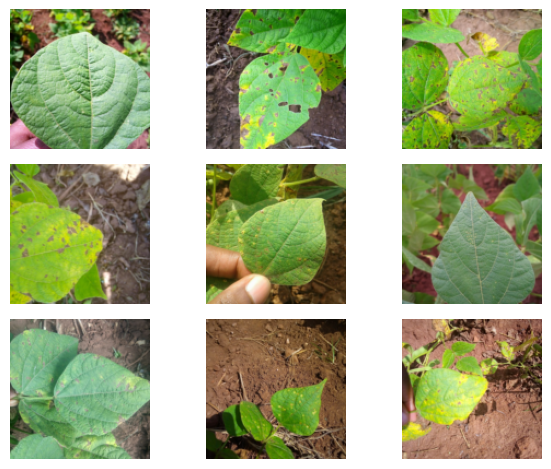

In [8]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
        image = train_dataset[np.random.randint(0,train_dataset.__len__())][0].cpu()
        axarr[row, col].imshow((image*255).squeeze().permute(1,2,0))
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

In [9]:
LR=1e-3
BATCH_SIZE=4
EPOCHS=15


In [10]:
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [11]:
googlenet_model=models.googlenet(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 77.4MB/s]


In [12]:
for param in googlenet_model.parameters():
  param.requires_grad=True


In [13]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [14]:
num_classes=len(train_df['category'].unique())
num_classes

3

In [15]:
googlenet_model.fc=torch.nn.Linear(googlenet_model.fc.in_features,num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [16]:

googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [17]:
loss_fun=nn.CrossEntropyLoss()
optimizer=Adam(googlenet_model.parameters(),lr=LR)

total_loss_train_plot=[]
total_acc_train_plot=[]

for epoch in range(EPOCHS):
  total_loss_train=0
  total_acc_train=0

  for inputs,labels in train_loader:
    optimizer.zero_grad()
    outputs=googlenet_model(inputs)
    train_loss=loss_fun(outputs,labels)
    total_loss_train+=train_loss.item()
    train_loss.backward()
    train_acc=(torch.argmax(outputs,axis=1)==labels).sum().item()
    total_acc_train+=train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100,4))
  print(f"Epoch{epoch+1}/{EPOCHS},Train Loss:{round(total_loss_train/1000,4)},Train Accuracy:{round(total_acc_train/train_dataset.__len__()*100,4)} %")

Epoch1/15,Train Loss:0.2462,Train Accuracy:55.706 %
Epoch2/15,Train Loss:0.2059,Train Accuracy:64.5068 %
Epoch3/15,Train Loss:0.2066,Train Accuracy:65.8607 %
Epoch4/15,Train Loss:0.1957,Train Accuracy:68.6654 %
Epoch5/15,Train Loss:0.1626,Train Accuracy:73.0174 %
Epoch6/15,Train Loss:0.1686,Train Accuracy:74.0812 %
Epoch7/15,Train Loss:0.1607,Train Accuracy:76.0155 %
Epoch8/15,Train Loss:0.145,Train Accuracy:77.9497 %
Epoch9/15,Train Loss:0.1391,Train Accuracy:78.6267 %
Epoch10/15,Train Loss:0.1274,Train Accuracy:81.8182 %
Epoch11/15,Train Loss:0.1298,Train Accuracy:81.3346 %
Epoch12/15,Train Loss:0.1139,Train Accuracy:83.4623 %
Epoch13/15,Train Loss:0.1199,Train Accuracy:81.4313 %
Epoch14/15,Train Loss:0.0947,Train Accuracy:86.2669 %
Epoch15/15,Train Loss:0.1177,Train Accuracy:81.9149 %


In [24]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(val_loader):

    prediction = googlenet_model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/val_dataset.__len__())*100, 2)}%")

Accuracy Score is: 47.37%


In [22]:
print(round(total_acc_test/val_dataset.__len__()*100,2))


47.37


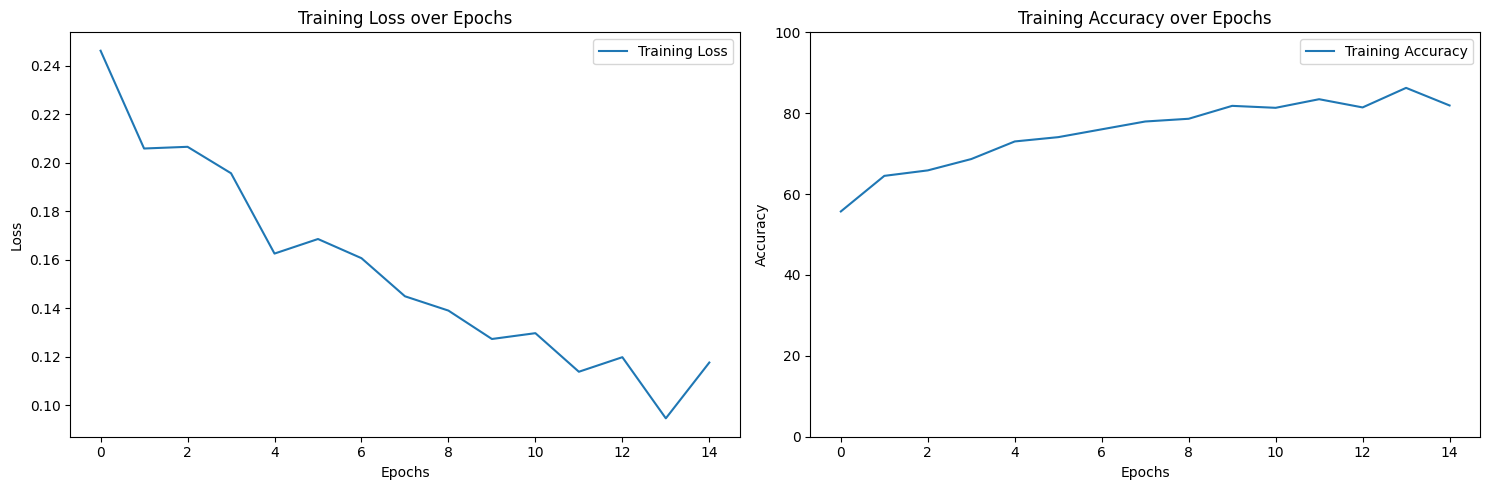

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()